### Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_score, recall_score, accuracy_score)
from sklearn. model_selection import StratifiedKFold, cross_validate, GridSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier


#### Load the dataset

In [2]:
X_train = np.load('./artifacts/X_train.npz', allow_pickle=True)['arr_0']
y_train = np.load('./artifacts/y_train.npz', allow_pickle=True)['arr_0']
X_test = np.load('./artifacts/X_test.npz', allow_pickle=True)['arr_0']
y_test = np.load('./artifacts/y_test.npz', allow_pickle=True)['arr_0']

In [3]:
model_lr = LogisticRegression(max_iter=1000, random_state=42)

model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

#### Inference

In [4]:
y_hat_train = model_lr.predict(X_train)
y_hat_test = model_lr.predict(X_test)

y_proba_train = model_lr.predict_proba(X_train)
y_proba_test = model_lr.predict_proba(X_test)

y_proba_train

array([[0.11136849, 0.88863151],
       [0.60770631, 0.39229369],
       [0.76986401, 0.23013599],
       ...,
       [0.07515522, 0.92484478],
       [0.17581038, 0.82418962],
       [0.61240734, 0.38759266]])

#### Evaluations

In [5]:
accuracy = accuracy_score(y_test, y_hat_test)
precision = precision_score(y_test, y_hat_test)
recall = recall_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.7423
Precision: 0.4906
Recall: 0.7415
F1 Score: 0.5905


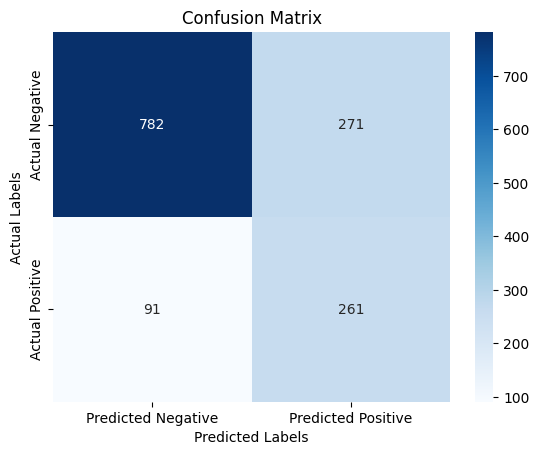

In [6]:
cm = confusion_matrix(y_test, y_hat_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

#### Multi Model Training

In [7]:
lr_param_grid = {
    'max_iter': [1000],
    'C': [2]
}

rf_param_grid = {
    'n_estimators': [600],
    'max_depth': [16, 25],
    'max_features': ['log2'],
    'criterion': ["entropy"]
}

xgb_param_grid = {
    'n_estimators': [100],
    'max_depth': [8, 10],
    'learning_rate': [0.1, 0.3],
    'subsample': [1.0],
    'colsample_bytree': [0.4]
}

cb_param_grid = {
    'iterations': [600],
    'depth': [12, 16],
    'learning_rate': [0.01],
    'l2_leaf_reg': [1],
    'auto_class_weights': ['Balanced'] 
}

param_grids = {
    'Logistic Regression': lr_param_grid,
    'Random Forest': rf_param_grid,
    'XGBoost': xgb_param_grid,
    'Cat Boost' : cb_param_grid
}


In [8]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier()#,
    #'XGBoost': XGBClassifier(),
    #'Cat Boost' : CatBoostClassifier()
}

In [9]:
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

#### Grid Search CV

In [10]:
grid_search_results = {}

for model_name, model in models.items():
    print(f"\n---Tunning {model_name} ---")
    param_grid = param_grids[model_name]
    
    grid_search =GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring='f1',
        verbose=1,
        return_train_score=False  
    )

    print(f"Fitting grid search for {model_name}...")
    grid_search.fit(X_train, y_train)

    grid_search_results[model_name] = grid_search.best_estimator_

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best estimator for {model_name}: {grid_search.best_estimator_}")
    print(f"Best CV Score for {model_name}: {grid_search.best_score_}")


---Tunning Logistic Regression ---
Fitting grid search for Logistic Regression...
Fitting 6 folds for each of 1 candidates, totalling 6 fits
Best parameters for Logistic Regression: {'C': 2, 'max_iter': 1000}
Best estimator for Logistic Regression: LogisticRegression(C=2, max_iter=1000)
Best CV Score for Logistic Regression: 0.8046381479107545

---Tunning Random Forest ---
Fitting grid search for Random Forest...
Fitting 6 folds for each of 2 candidates, totalling 12 fits
Best parameters for Random Forest: {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'log2', 'n_estimators': 600}
Best estimator for Random Forest: RandomForestClassifier(criterion='entropy', max_depth=16, max_features='log2',
                       n_estimators=600)
Best CV Score for Random Forest: 0.8408117614815701


In [11]:
grid_search_results

{'Logistic Regression': LogisticRegression(C=2, max_iter=1000),
 'Random Forest': RandomForestClassifier(criterion='entropy', max_depth=16, max_features='log2',
                        n_estimators=600)}

#### Inference and Evaluations

In [12]:
y_hat_test = {}

for model_name, model in grid_search_results.items():
    y_hat_test[model_name] = model.predict(X_test)
    print(f"{model_name} accuracy score: {accuracy_score(y_test, y_hat_test[model_name])}")
    print(f"{model_name} precision score: {precision_score(y_test, y_hat_test[model_name])}")
    print(f"{model_name} recall score: {recall_score(y_test, y_hat_test[model_name])}")
    print(f"{model_name} f1 score: {f1_score(y_test, y_hat_test[model_name])}")
    

Logistic Regression accuracy score: 0.7416370106761566
Logistic Regression precision score: 0.4896030245746692
Logistic Regression recall score: 0.7357954545454546
Logistic Regression f1 score: 0.5879682179341658
Random Forest accuracy score: 0.7523131672597865
Random Forest precision score: 0.5042735042735043
Random Forest recall score: 0.6704545454545454
Random Forest f1 score: 0.5756097560975609


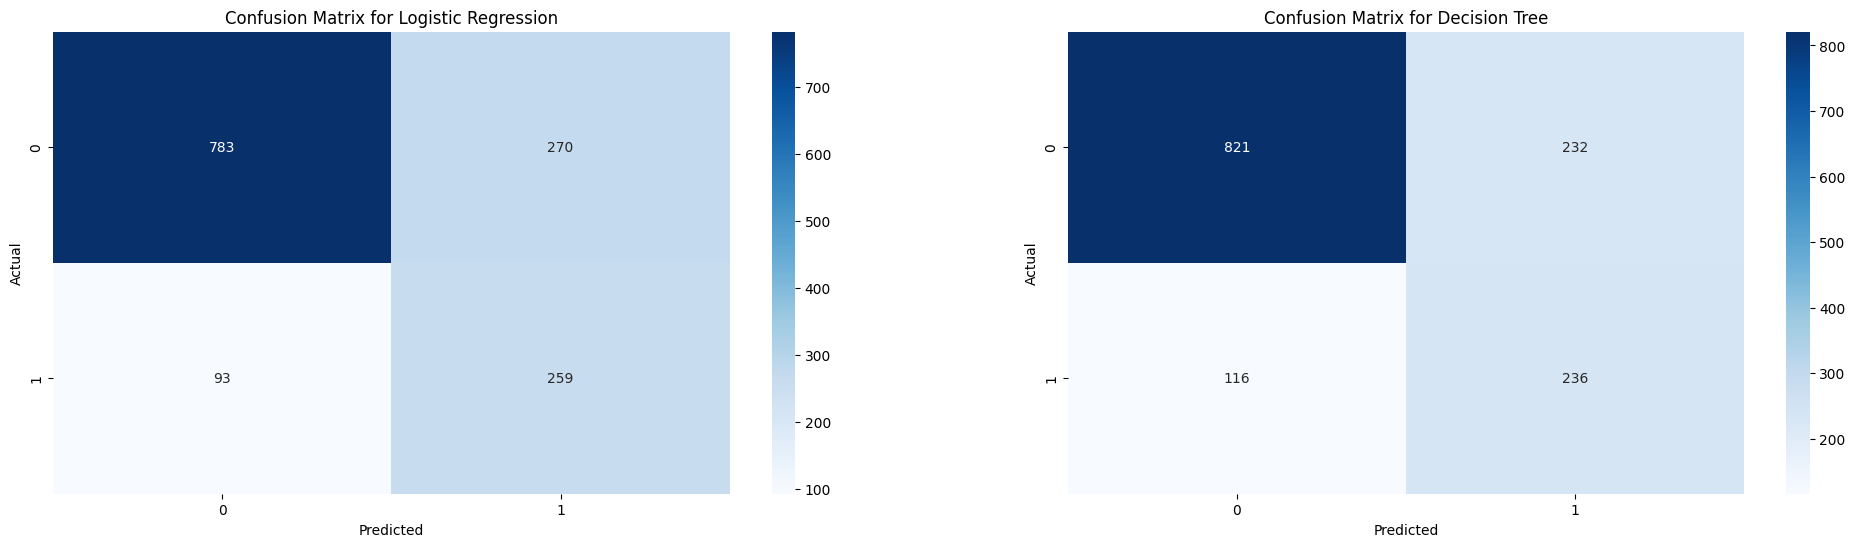

In [13]:
cm1 = confusion_matrix(y_test, y_hat_test['Logistic Regression'])
cm2 = confusion_matrix(y_test, y_hat_test['Random Forest'])
# cm3 = confusion_matrix(y_test, y_hat_test['XGBoost'])
# cm4 = confusion_matrix(y_test, y_hat_test['Cat Boost'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Confusion Matrix for Logistic Regression')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Confusion Matrix for Decision Tree')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

# sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', ax=ax3)
# ax3.set_title('Confusion Matrix for Random Forest')
# ax3.set_xlabel('Predicted')
# ax3.set_ylabel('Actual')

# sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues', ax=ax4)
# ax4.set_title('Confusion Matrix for Cat Boost')
# ax4.set_xlabel('Predicted')
# ax4.set_ylabel('Actual')

plt.show()
